# Обучение модели детекции нарушений СИЗ

## Imports

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
from pathlib import Path
import os
from pprint import pformat

from pydantic import BaseModel, Field
from detectron2.utils.logger import setup_logger
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.evaluation import COCOEvaluator

from ppe_modelling.utils import system_info_banner, current_run_tag
from ppe_modelling.logger import logger
from ppe_modelling.detectron_utils import register_coco_ds, visualize_ds, infer_ds
from ppe_modelling.detectron_cfg import configure_cfg, get_infer_cfg

detectron_logger = setup_logger()

## System info

In [13]:
logger.info(system_info_banner())

[ppe-modelling] 06.04.2025 18:58:10 === System Information ===
System: Linux
Machine: x86_64
OS Version: #59~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Mar 19 17:07:41 UTC 2
OS Name: Linux-6.8.0-57-generic-x86_64-with-glibc2.35

=== Hardware Information ===
RAM: 62.64 GB
CPU: x86_64 (20 cores)
GPU: NVIDIA GeForce RTX 3090
nvcc: nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0

=== Libraries Information ===
torch: 2.6; cuda: cu124
detectron2: 0.6


## Settings

In [ ]:
class PPETrainSettings(BaseModel):
    coco_ds_dir: Path = Path('../data/construction-site-safety-image-dataset-roboflow-coco-apr-6')
    classes: dict = {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}
    output_dir: Path = Path('../logs/')
    run_tag: str = Field(default_factory=current_run_tag)

train_settings = PPETrainSettings()


logger.info("\n" + pformat(train_settings.model_dump()))

[ppe-modelling] 06.04.2025 18:58:10 
{'classes': {0: 'Hardhat',
             1: 'Mask',
             2: 'NO-Hardhat',
             3: 'NO-Mask',
             4: 'NO-Safety Vest',
             5: 'Person',
             6: 'Safety Cone',
             7: 'Safety Vest',
             8: 'machinery',
             9: 'vehicle'},
 'coco_ds_dir': PosixPath('../data/construction-site-safety-image-dataset-roboflow-coco-apr-6'),
 'output_dir': PosixPath('../logs'),
 'run_tag': '06apr-18_58_10'}


## Register Datasets

In [15]:
TRAIN_DS_DETECTRON_TAG = 'ppe_ds_train'
VAL_DS_DETECTRON_TAG = 'ppe_ds_val'
TEST_DS_DETECTRON_TAG = 'ppe_ds_test'
PPE_COCO_INSTANCES_DS_PATH = train_settings.coco_ds_dir
CLASSES = train_settings.classes

register_coco_ds(PPE_COCO_INSTANCES_DS_PATH, 'train', TRAIN_DS_DETECTRON_TAG)
register_coco_ds(PPE_COCO_INSTANCES_DS_PATH, 'val', VAL_DS_DETECTRON_TAG)
register_coco_ds(PPE_COCO_INSTANCES_DS_PATH, 'test', TEST_DS_DETECTRON_TAG)

In [16]:
ds_train = DatasetCatalog.get(TRAIN_DS_DETECTRON_TAG)
ds_train_meta = MetadataCatalog.get(TRAIN_DS_DETECTRON_TAG)

ds_val = DatasetCatalog.get(VAL_DS_DETECTRON_TAG)
ds_val_meta = MetadataCatalog.get(VAL_DS_DETECTRON_TAG)

ds_test = DatasetCatalog.get(TEST_DS_DETECTRON_TAG)
ds_test_meta = MetadataCatalog.get(TEST_DS_DETECTRON_TAG)

[04/06 18:58:10 d2.data.datasets.coco]: Loaded 2605 images in COCO format from ../data/construction-site-safety-image-dataset-roboflow-coco-apr-6/annotations/instances_train.json
[04/06 18:58:10 d2.data.datasets.coco]: Loaded 114 images in COCO format from ../data/construction-site-safety-image-dataset-roboflow-coco-apr-6/annotations/instances_val.json
[04/06 18:58:10 d2.data.datasets.coco]: Loaded 82 images in COCO format from ../data/construction-site-safety-image-dataset-roboflow-coco-apr-6/annotations/instances_test.json


## Visualize data

### Train

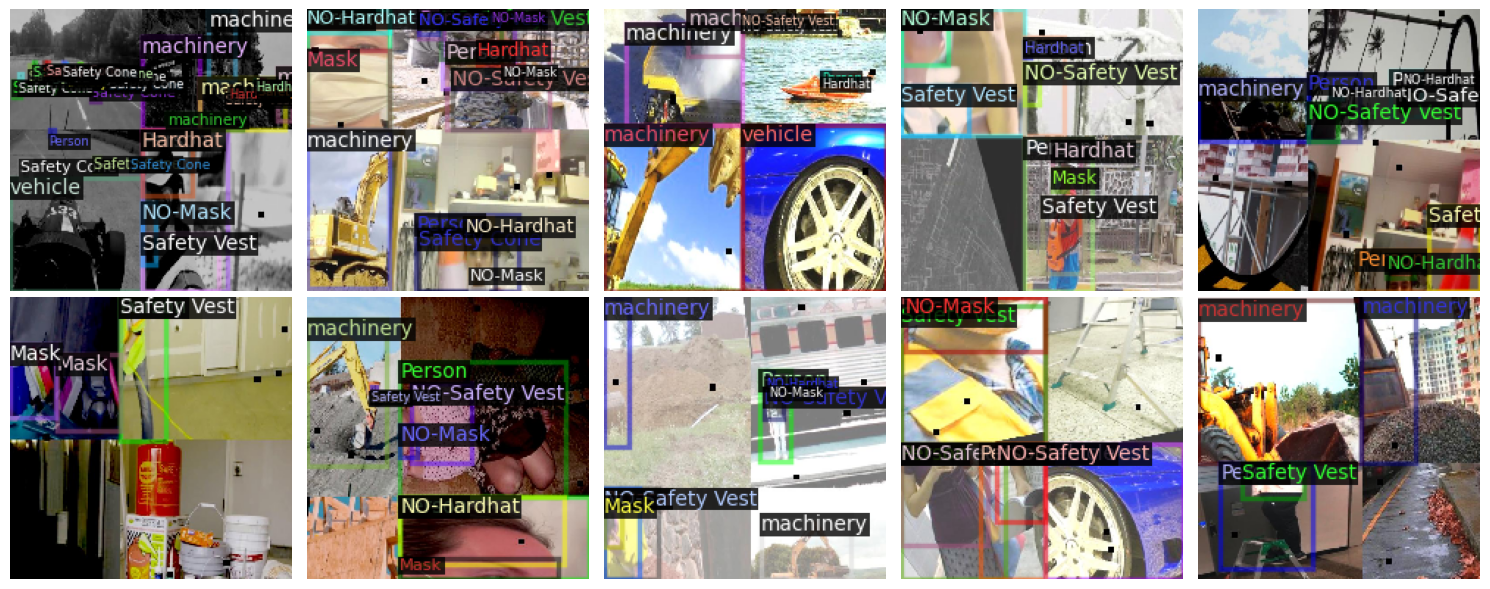

In [17]:
_ = visualize_ds(ds_train, ds_train_meta, n=10, cols=5)

### Val

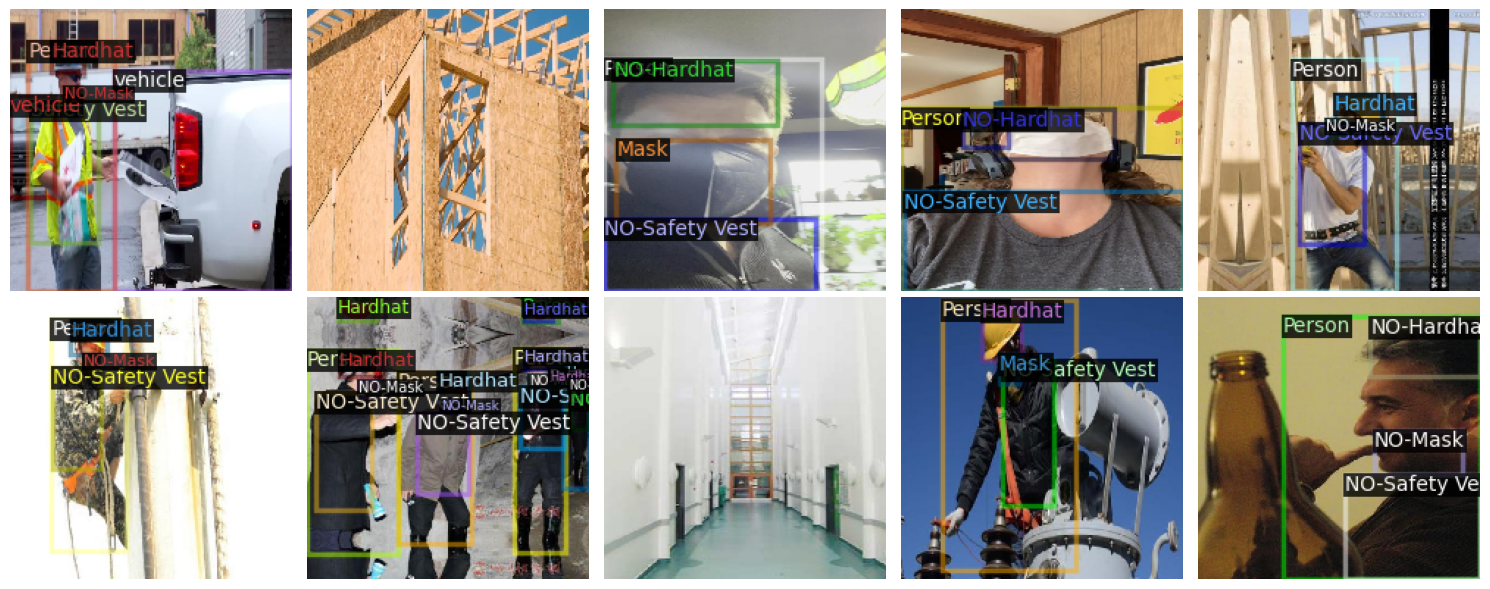

In [18]:
_ = visualize_ds(ds_val, ds_val_meta, n=10, cols=5)

### Test

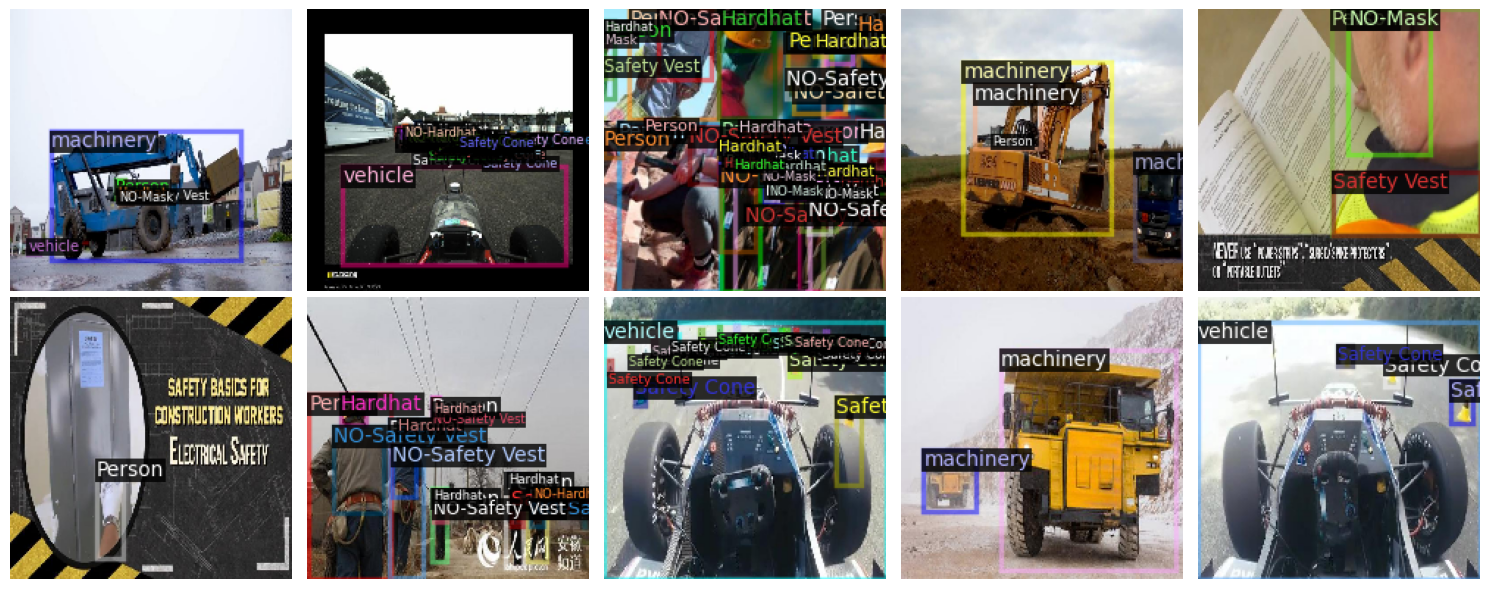

In [19]:
_ = visualize_ds(ds_test, ds_test_meta, n=10, cols=5)


## Train

### Define configuration

In [31]:
def get_train_cfg(output_dir, config_file: str):
    return configure_cfg(
        len(CLASSES),
        [TRAIN_DS_DETECTRON_TAG],
        [TEST_DS_DETECTRON_TAG, VAL_DS_DETECTRON_TAG],
        config_file=config_file,
        output_dir=output_dir,
    )

config_file = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"
output_dir = train_settings.output_dir / 'ppe_train' / train_settings.run_tag
cfg = get_train_cfg(output_dir, config_file)


[04/06 19:03:35 d2.data.datasets.coco]: Loaded 2605 images in COCO format from ../data/construction-site-safety-image-dataset-roboflow-coco-apr-6/annotations/instances_train.json


### Log configuration

In [32]:
logger.info(cfg)

[ppe-modelling] 06.04.2025 19:03:40 CUDNN_BENCHMARK: False
DATALOADER:
  ASPECT_RATIO_GROUPING: True
  FILTER_EMPTY_ANNOTATIONS: True
  NUM_WORKERS: 2
  REPEAT_SQRT: True
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: ()
  PROPOSAL_FILES_TRAIN: ()
  TEST: ['ppe_ds_test', 'ppe_ds_val']
  TRAIN: ['ppe_ds_train']
FLOAT32_PRECISION: 
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: False
    SIZE: [0.9, 0.9]
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN: (640, 672, 704, 736, 768, 800)
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES: [[-90, 0, 90]]
    ASPECT_RATIOS: [[0.5, 1.0, 2.0]]
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES: [[32], [64], [128], [256], [512]]
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resn

### Define trainer

In [33]:
# self.trainer.storage.latest() - gives latest metrics...
# class TrainerBase:
#     def __init__(self) -> None:
#         self.storage: EventStorage
# However, no calls are being made that can be of mask-rcnn. That comes from model?

class CocoTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "coco_evaluator_val")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    def build_hooks(self):
        hooks = super().build_hooks()
        # best_checkpoint_hook = BestCheckpointer(
        #     self.cfg.TEST.EVAL_PERIOD,
        #     checkpointer=self.checkpointer,
        #     # val_metric='bbox/ap' TODO: figure out the metric for val
        # )
        new_hooks = [
            # best_checkpoint_hook,
        ]
        hooks.extend(new_hooks)
        return hooks

trainer = CocoTrainer(cfg)
trainer.resume_or_load()
logger.info(trainer._hooks)

[04/06 19:03:42 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (11, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (11,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (40, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (40,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias

### Run Train

In [ ]:
results = trainer.train()
logger.info("\n" + pformat(results))

[04/06 17:24:51 d2.engine.train_loop]: Starting training from iteration 0


/home/quakumei/.pyenv/versions/ppe-modelling/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[04/06 17:25:05 d2.utils.events]:  eta: 0:44:01  iter: 19  total_loss: 4.192  loss_cls: 2.365  loss_box_reg: 0.8511  loss_rpn_cls: 0.7417  loss_rpn_loc: 0.2505    time: 0.6252  last_time: 0.6823  data_time: 0.0940  last_data_time: 0.1180   lr: 1.9981e-05  max_mem: 7067M
[04/06 17:25:17 d2.utils.events]:  eta: 0:43:30  iter: 39  total_loss: 3.632  loss_cls: 2.086  loss_box_reg: 0.8384  loss_rpn_cls: 0.5766  loss_rpn_loc: 0.2294    time: 0.6186  last_time: 0.5911  data_time: 0.0964  last_data_time: 0.0817   lr: 3.9961e-05  max_mem: 7067M
[04/06 17:25:29 d2.utils.events]:  eta: 0:43:07  iter: 59  total_loss: 2.984  loss_cls: 1.576  loss_box_reg: 0.8154  loss_rpn_cls: 0.3312  loss_rpn_loc: 0.2293    time: 0.6144  last_time: 0.6255  data_time: 0.0999  last_data_time: 0.1120   lr: 5.9941e-05  max_mem: 7067M
[04/06 17:25:42 d2.utils.events]:  eta: 0:42:57  iter: 79  total_loss: 2.39  loss_cls: 1.074  loss_box_reg: 0.7787  loss_rpn_cls: 0.2662  loss_rpn_loc: 0.2501    time: 0.6132  last_time: 

[ppe-modelling] 06.04.2025 18:11:13 
None


## Eval model

### Define predictor

In [36]:
print(len(CLASSES))

10


In [35]:
output_dir = train_settings.output_dir / 'ppe_train' / '06apr-17_24_43'
model_file = "model_0004224.pth"
model_path = output_dir / model_file
config_file = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

cfg = get_infer_cfg(str(model_path), config_file, len(CLASSES))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
predictor = DefaultPredictor(cfg)

[04/06 19:04:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../logs/ppe_train/06apr-17_24_43/model_0004224.pth ...


### Infer Train

/home/quakumei/.pyenv/versions/ppe-modelling/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


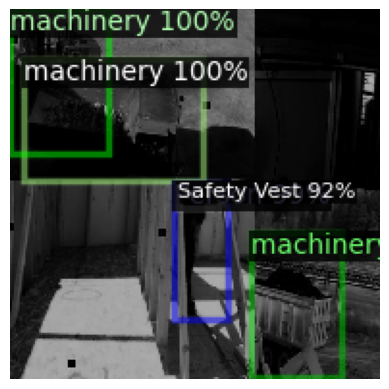

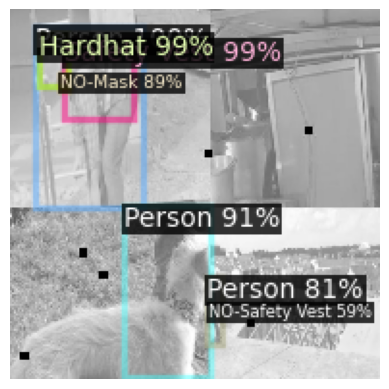

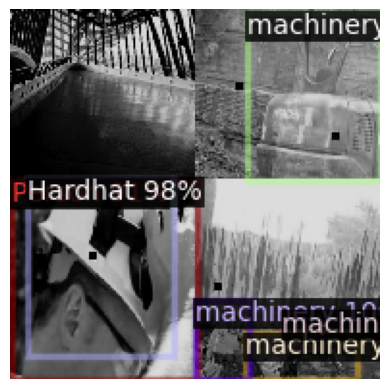

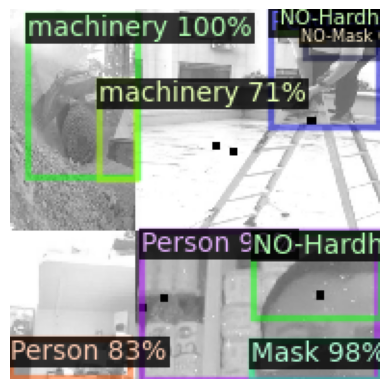

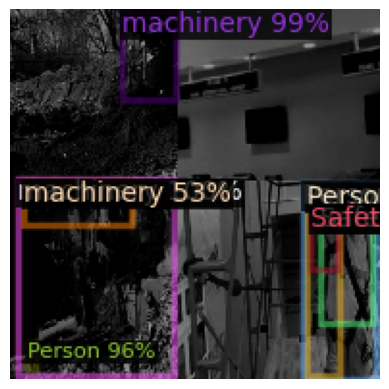

In [27]:
train_samples, train_predictions = infer_ds(predictor, ds_train, ds_train_meta, n=5)

### Infer Test

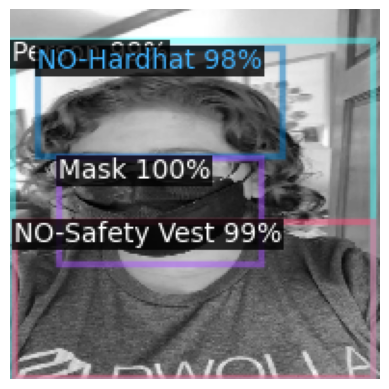

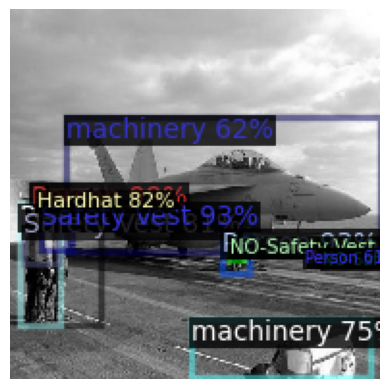

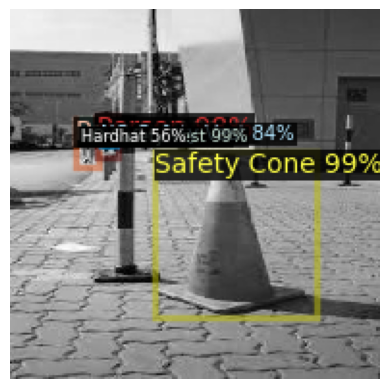

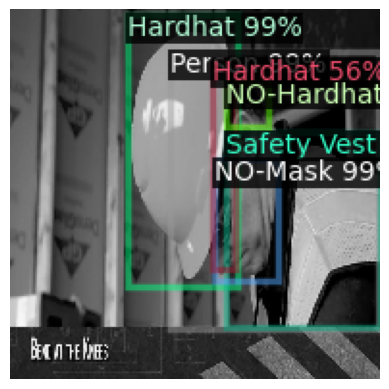

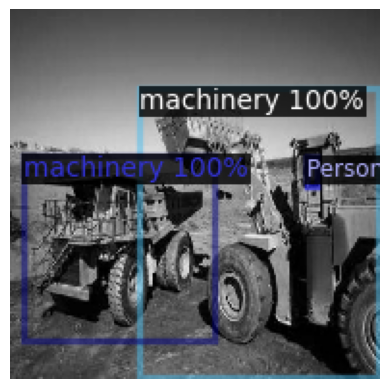

In [28]:
test_samples, test_predictions = infer_ds(predictor, ds_test, ds_test_meta, n=5)